In [1]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
%matplotlib inline

### 1 represents a negative tweet 
### 0 represents a non-negative tweet.

In [2]:
df=pd.read_csv("/kaggle/input/sentimenttraindataset/train_2kmZucJ.csv")

In [3]:
wordcloud_mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

In [4]:
df.head()

id  label                                              tweet
0   1      0  #fingerprint #Pregnancy Test https://goo.gl/h1...
1   2      0  Finally a transparant silicon case ^^ Thanks t...
2   3      0  We love this! Would you go? #talk #makememorie...
3   4      0  I'm wired I know I'm George I was made that wa...
4   5      1  What amazing service! Apple won't even talk to...

In [5]:
df.shape

(7920, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [7]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

# Clean Train Data

#  remove URL's from train 

In [8]:
df['clean_tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

# remove punctuation marks

In [9]:
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase

In [10]:
df['clean_tweet'] = df['clean_tweet'].str.lower()

# remove numbers

In [11]:
df['clean_tweet'] = df['clean_tweet'].str.replace("[0-9]", " ")


# remove whitespaces

In [12]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:' '.join(x.split()))

# lemmatize (normalize) the text

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [14]:
df['clean_tweet'] = lemmatization(df['clean_tweet'])

In [15]:
df.drop(columns=["id","tweet"],axis=1,inplace=True)

In [16]:
df.head()

label                                        clean_tweet
0      0  fingerprint pregnancy test android app beautif...
1      0  finally a transparant silicon case thank to my...
2      0  we love this would you go talk makememorie unp...
3      0  I be wire I know I be george I be make that wa...
4      1  what amazing service apple will not even talk ...

# Clean Test Data

In [17]:
test_data=pd.read_csv("/kaggle/input/test-data/test_oJQbWVk.csv")

In [18]:
test_data.head()

id                                              tweet
0  7921  I hate the new #iphone upgrade. Won't let me d...
1  7922  currently shitting my fucking pants. #apple #i...
2  7923  I'd like to puts some CD-ROMS on my iPad, is t...
3  7924  My ipod is officially dead. I lost all my pict...
4  7925  Been fighting iTunes all night! I only want th...

In [19]:
test_data['clean_tweet'] = test_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test_data['clean_tweet'] = test_data['clean_tweet'].str.lower()
test_data['clean_tweet'] = test_data['clean_tweet'].str.replace("[0-9]", " ")
test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: ' '.join(x.split()))

In [20]:
test_data.drop(columns=["tweet"],axis=1,inplace=True)

In [21]:
test_data.head()

id                                        clean_tweet
0  7921  i hate the new iphone upgrade. won't let me do...
1  7922  currently shitting my fucking pants. apple ima...
2  7923  i'd like to puts some cdroms on my ipad, is th...
3  7924  my ipod is officially dead. i lost all my pict...
4  7925  been fighting itunes all night i only want the...

# Visualize Data From Train Data

In [22]:
df.head()

label                                        clean_tweet
0      0  fingerprint pregnancy test android app beautif...
1      0  finally a transparant silicon case thank to my...
2      0  we love this would you go talk makememorie unp...
3      0  I be wire I know I be george I be make that wa...
4      1  what amazing service apple will not even talk ...

In [23]:
df["label"].value_counts()

label
0    5894
1    2026
Name: count, dtype: int64

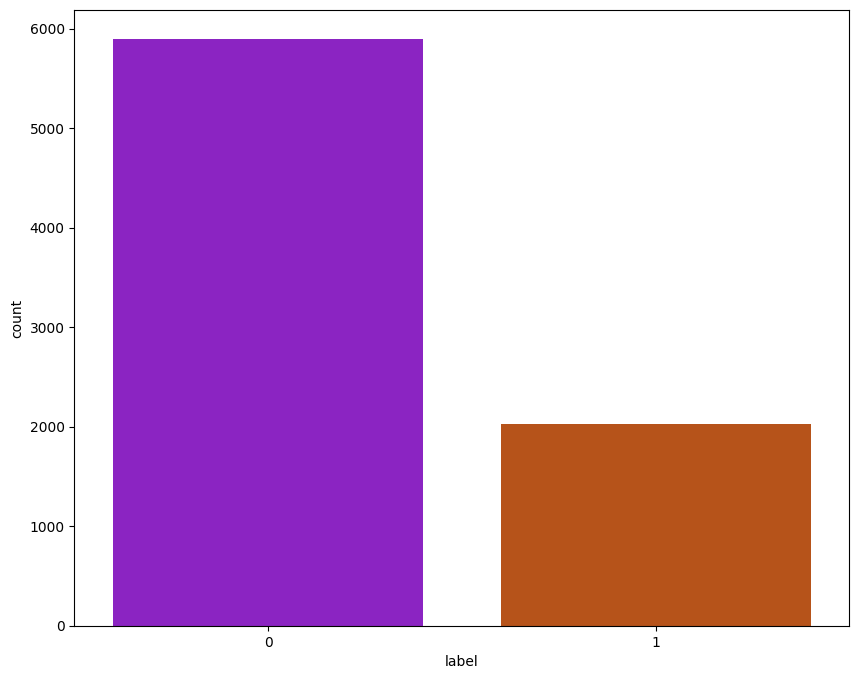

In [24]:
plt.figure(figsize=(10,8))
sns.countplot(x="label",data=df,palette="gnuplot")
plt.show()

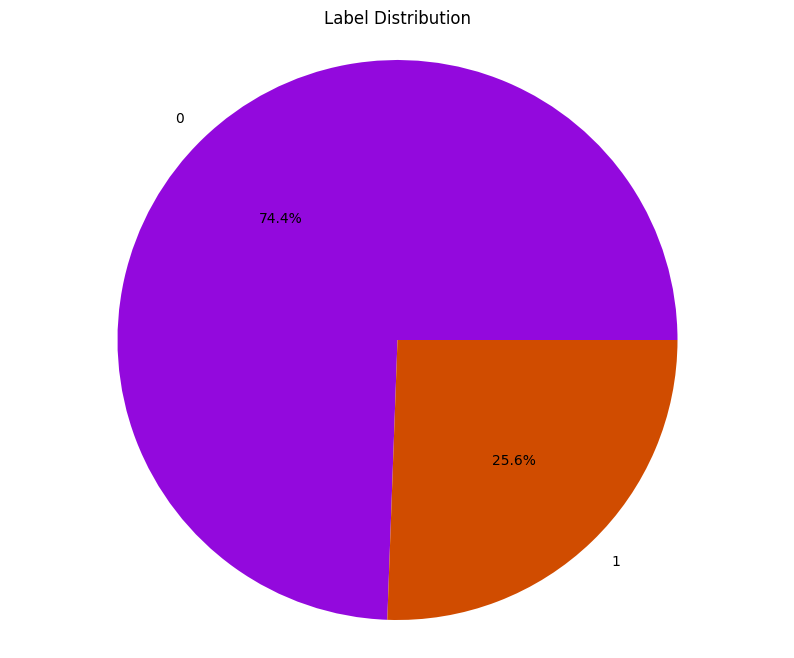

In [25]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(10,8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette("gnuplot", len(label_counts)))
plt.title('Label Distribution')
plt.axis("equal")
plt.show()

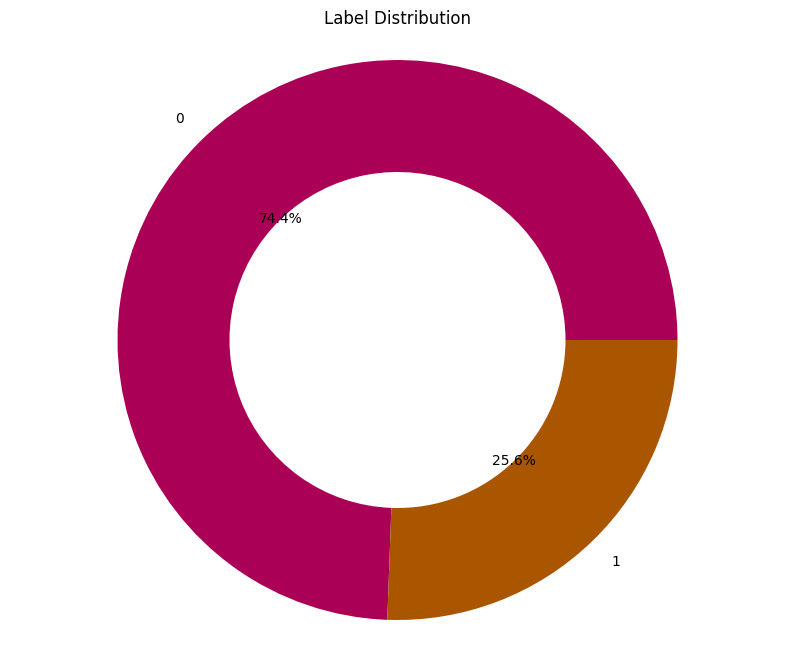

In [26]:
plt.figure(figsize=(10,8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette("brg", len(label_counts)), wedgeprops=dict(width=0.4))
plt.title('Label Distribution')
plt.axis("equal")
plt.show()

# Positive Data Length

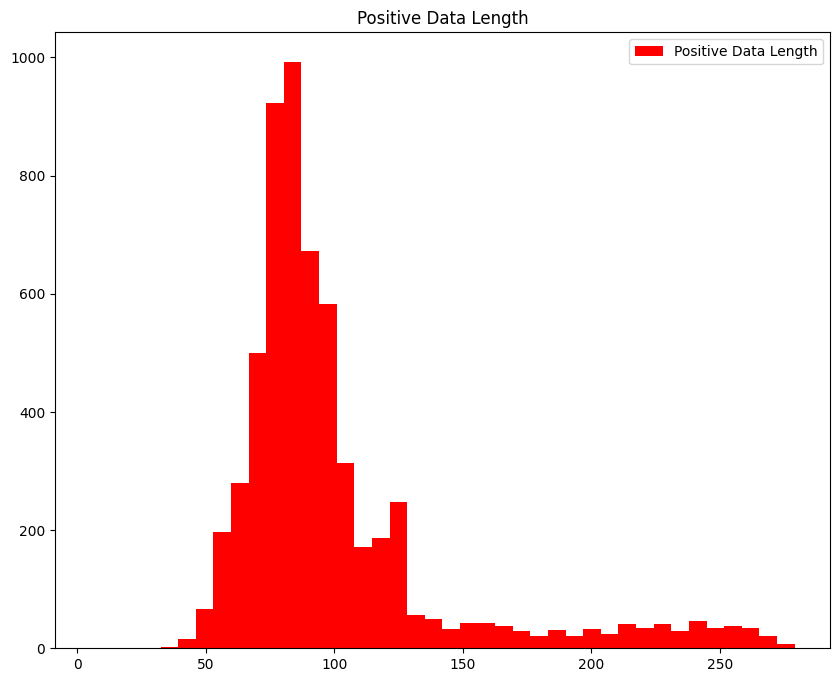

In [27]:
plt.figure(figsize=(10,8))
positive_len=df[df["label"]==0]["clean_tweet"].str.len()
plt.hist(positive_len, bins=40,label='Positive Data Length',color="red")
plt.title("Positive Data Length")
plt.legend()
plt.show()

# Negative Data Length

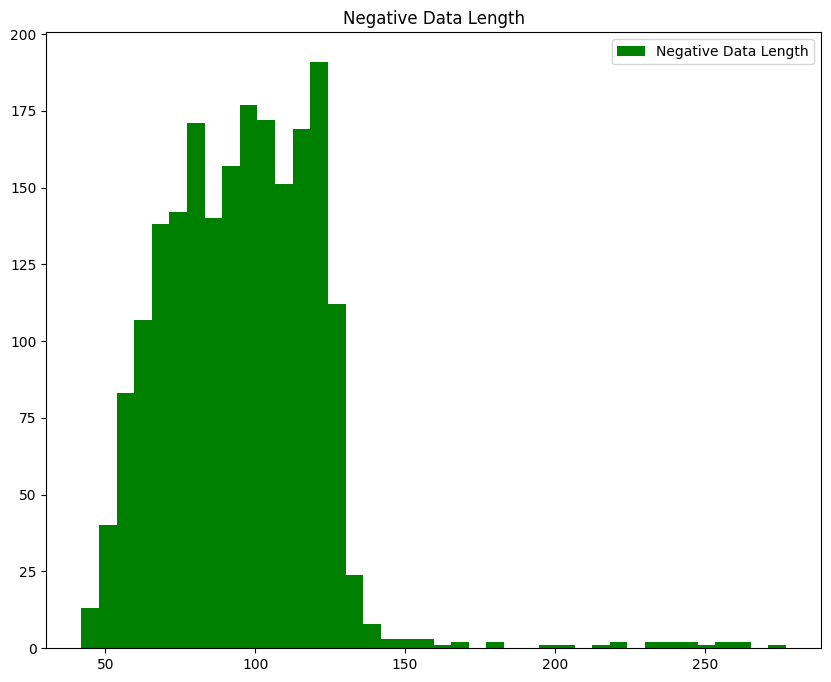

In [28]:
plt.figure(figsize=(10,8))
negative_len=df[df["label"]==1]["clean_tweet"].str.len()
plt.hist(negative_len, bins=40,label='Negative Data Length',color="green")
plt.title("Negative Data Length")
plt.legend()
plt.show()

# Compare Positive & Negative

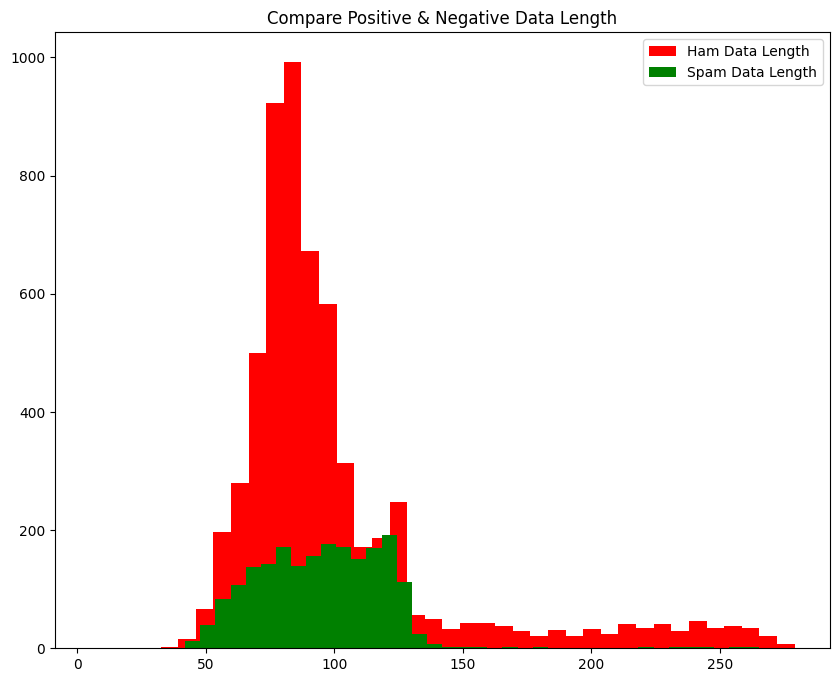

In [29]:
plt.figure(figsize=(10,8))

plt.hist(positive_len, bins=40,label='Ham Data Length',color="red")
plt.hist(negative_len, bins=40,label='Spam Data Length',color="green")
plt.title("Compare Positive & Negative Data Length")
plt.legend()
plt.show()

# ALL Data WordCloud

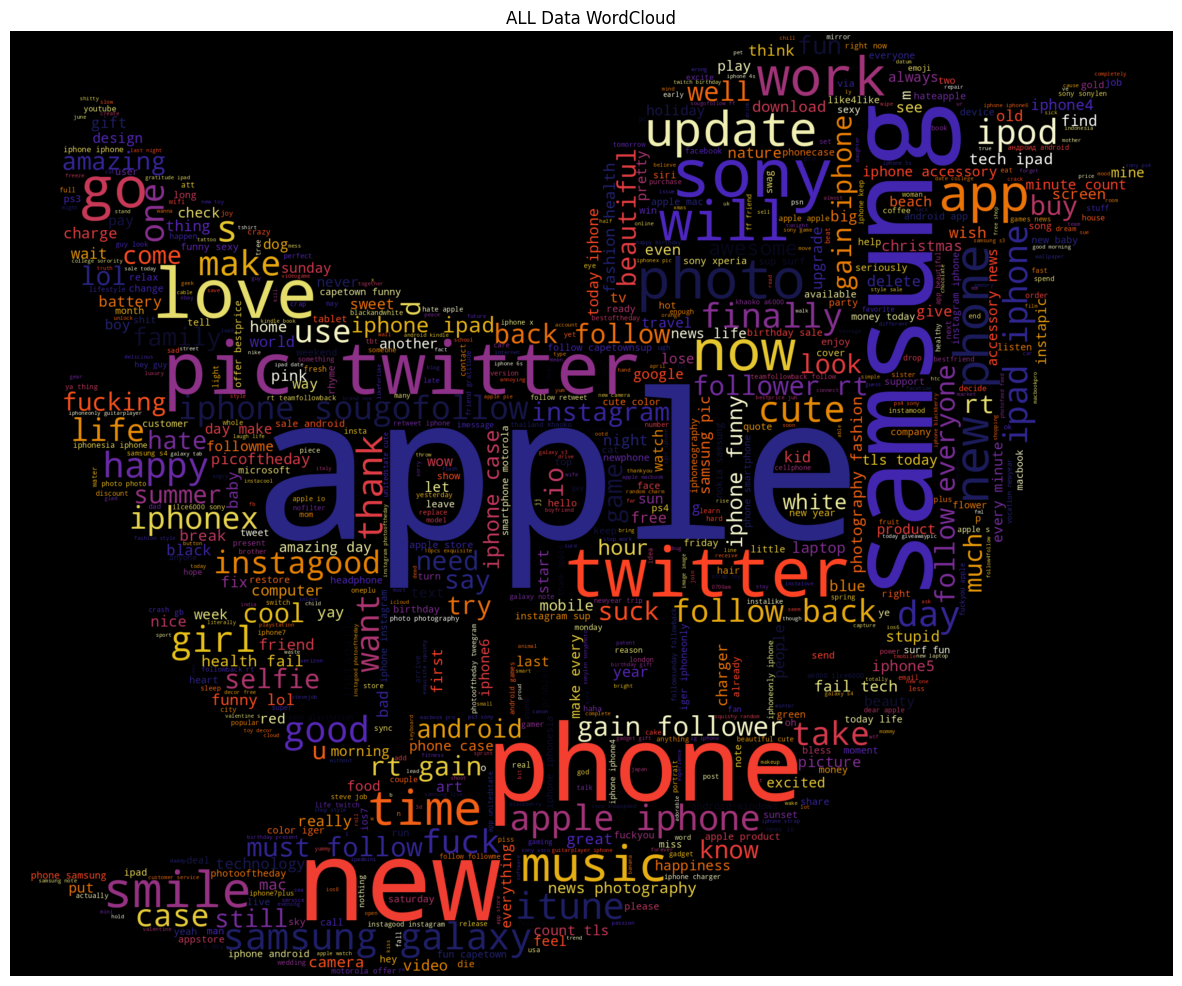

In [30]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
all_text=" ".join(df['clean_tweet'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("ALL Data WordCloud")
plt.show()

# Positive Data WordCloud

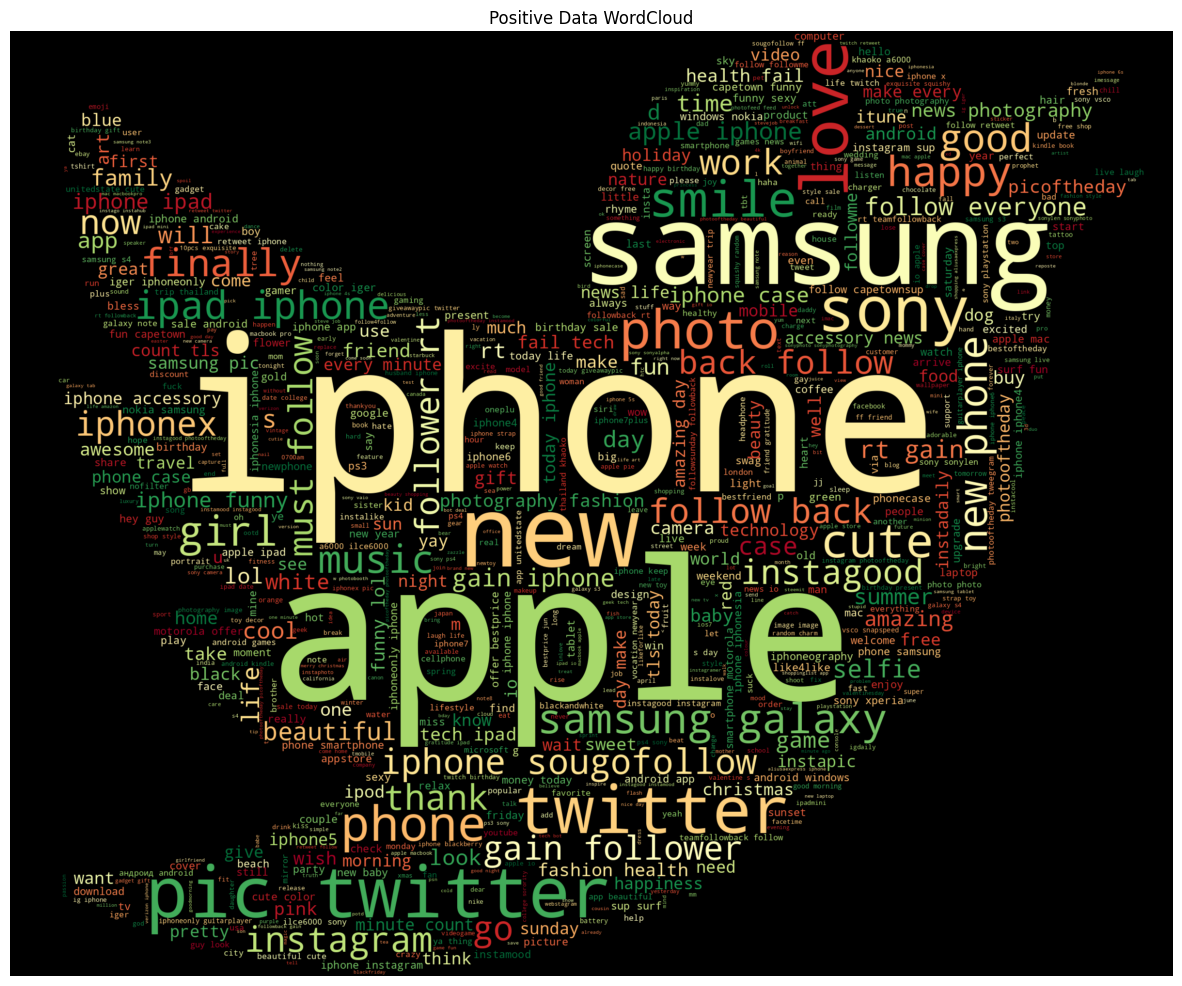

In [31]:
plt.figure(figsize=(15,15))
positive_wordcloud=df[df["label"]==0]
positive_text=" ".join(positive_wordcloud['clean_tweet'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="RdYlGn",mask=wordcloud_mask).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Data WordCloud")
plt.axis('off')
plt.show()

# Negative Data WordCloud

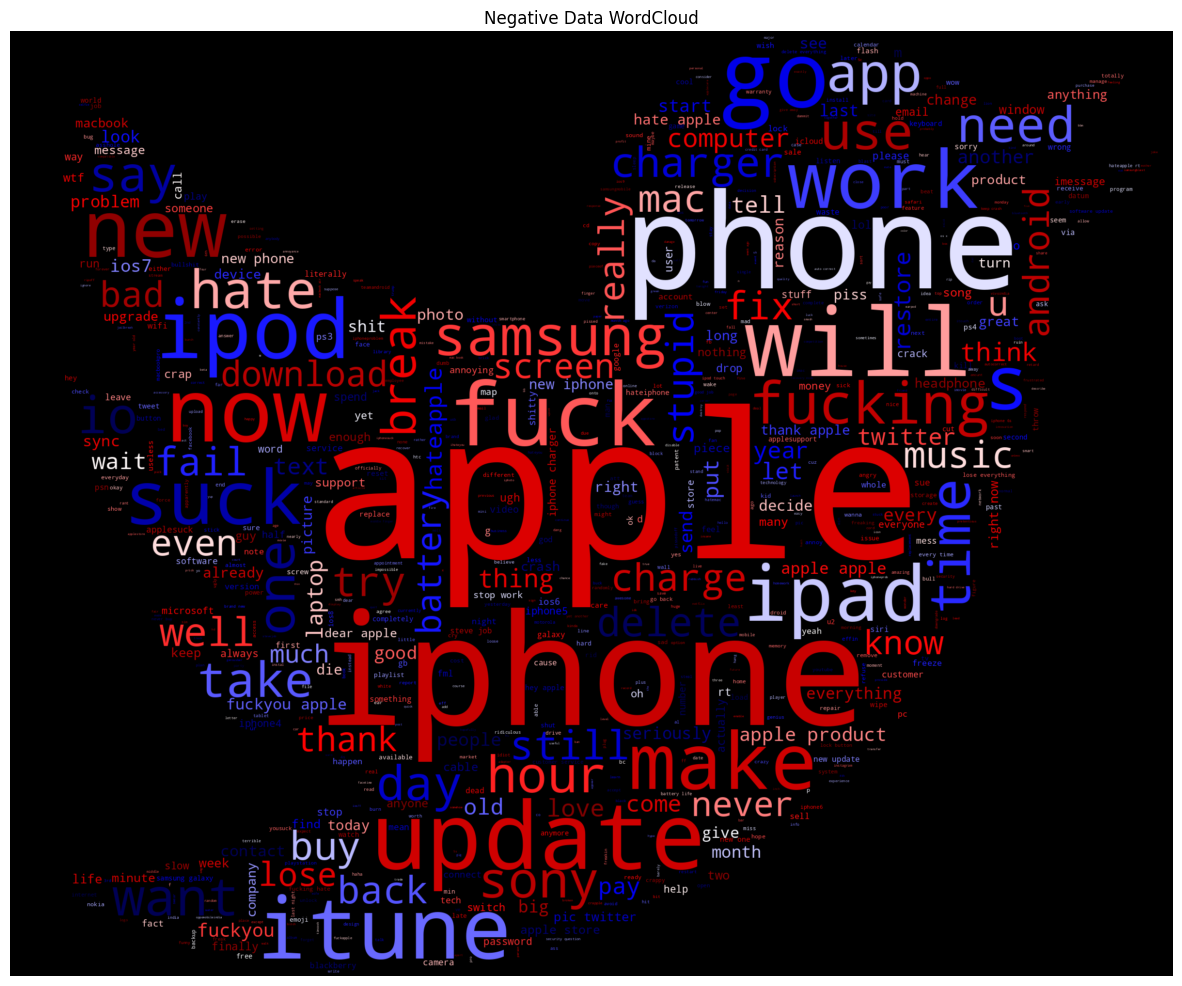

In [32]:
plt.figure(figsize=(15,15))
negative_wordcloud=df[df["label"]==1]
negative_text=" ".join(negative_wordcloud['clean_tweet'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="seismic",mask=wordcloud_mask).generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Data WordCloud")
plt.axis('off')
plt.show()

# 30 Most common Words From All Text

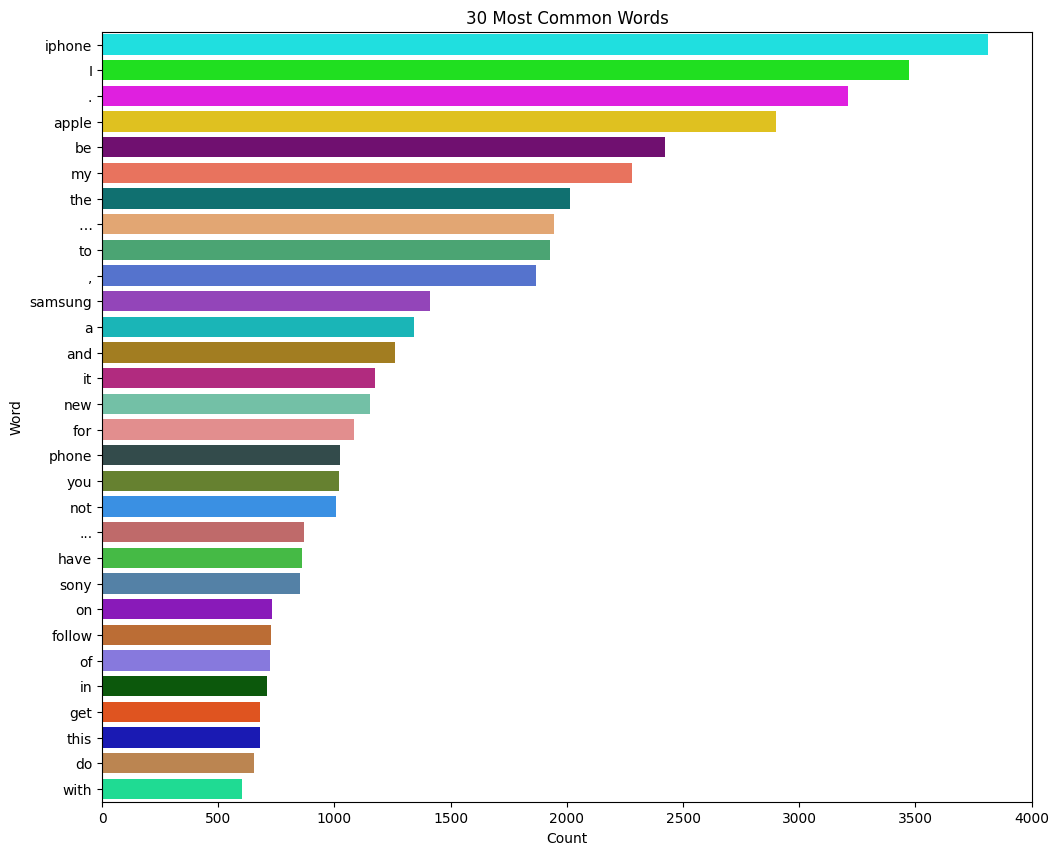

In [33]:
from itertools import chain
from collections import Counter

data_set =df["clean_tweet"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 10))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Most Common Words From Positive Text

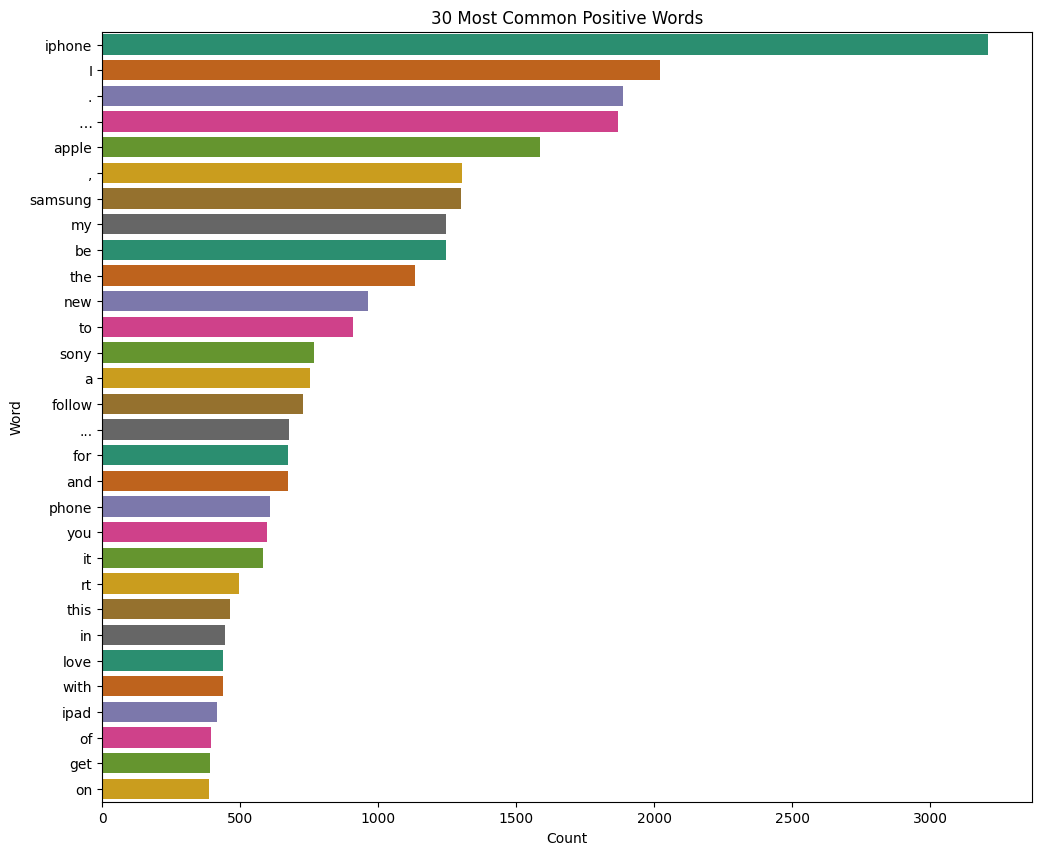

In [34]:
positive_text = df[df["label"] == 0]
data_set = positive_text["clean_tweet"].str.split()
all_words = [word for sublist in data_set for word in sublist]

counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 10))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=sns.color_palette("Dark2", n_colors=len(df_common_words)))
plt.title('30 Most Common Positive Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Most Common Words From Negative Text

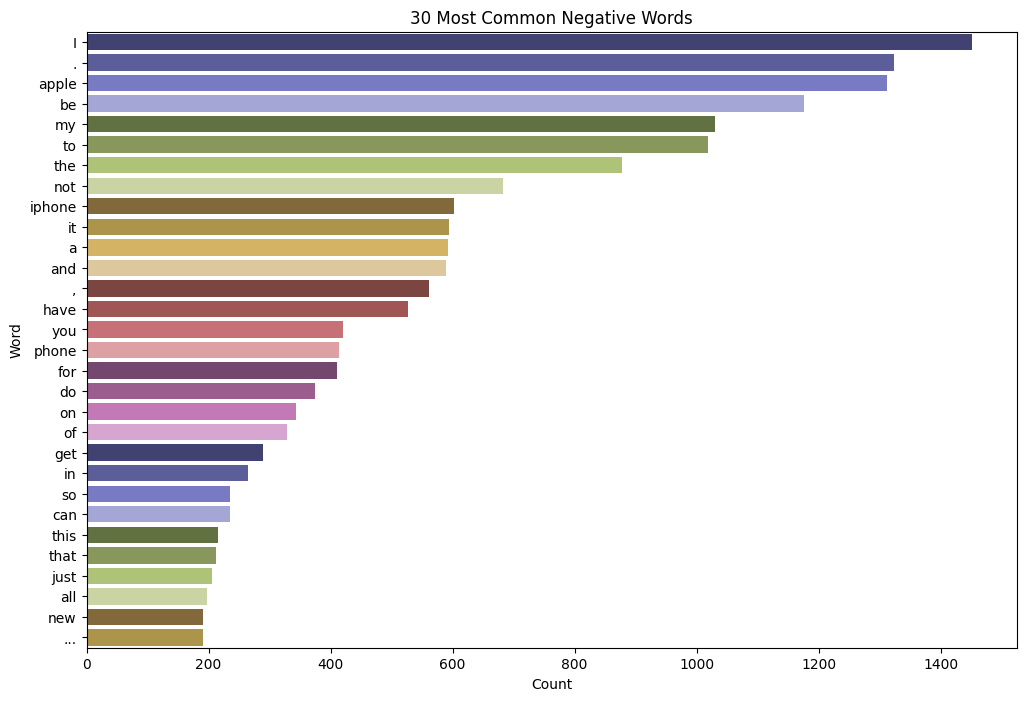

In [35]:
negative_text = df[df["label"] == 1]
data_set = negative_text["clean_tweet"].str.split()
all_words = [word for sublist in data_set for word in sublist]

counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=sns.color_palette("tab20b", n_colors=len(df_common_words)))
plt.title('30 Most Common Negative Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


# Visualize Data From Test Data

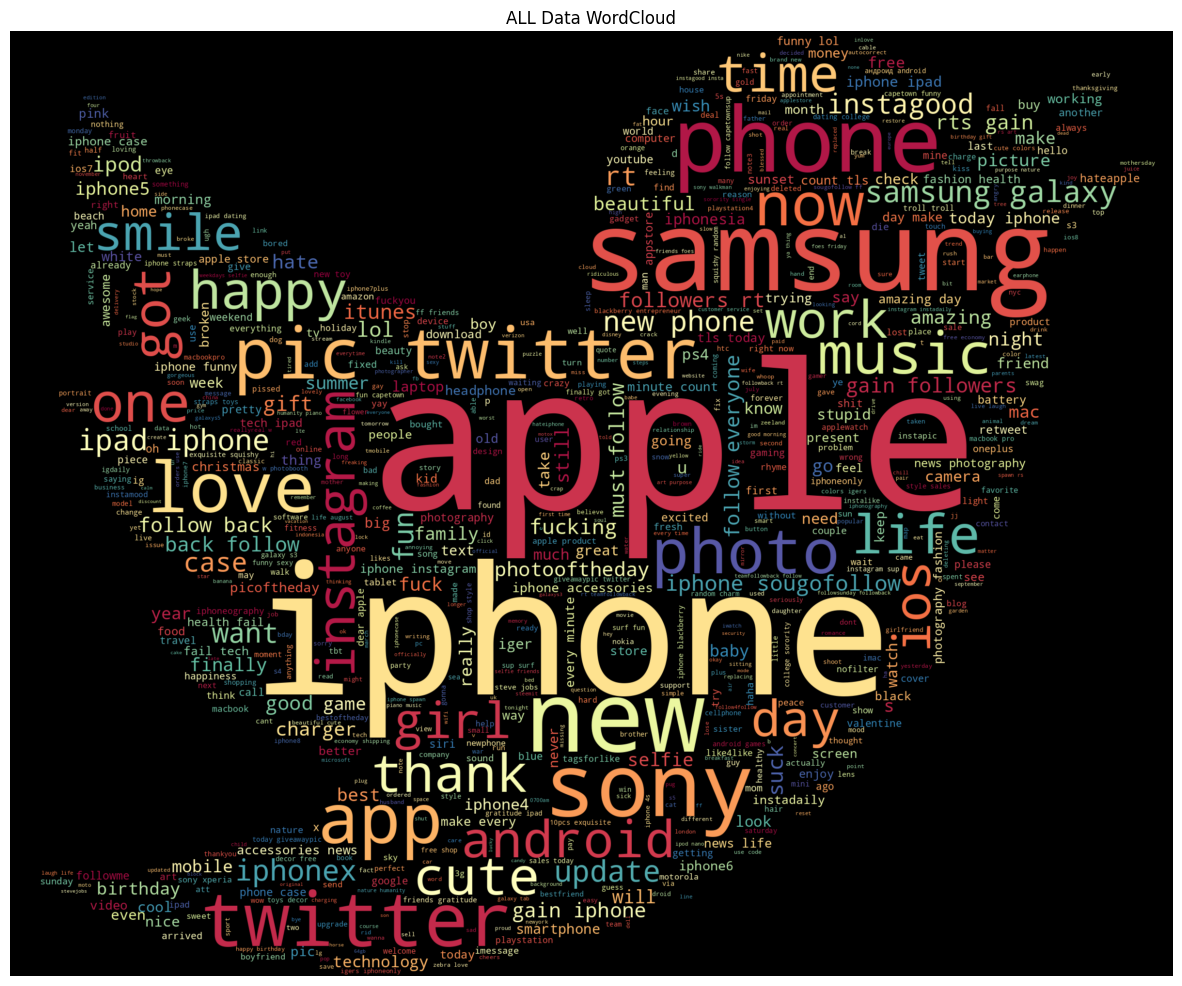

In [36]:

plt.figure(figsize=(15,15))
all_text=" ".join(test_data['clean_tweet'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Spectral",mask=wordcloud_mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("ALL Data WordCloud")
plt.show()

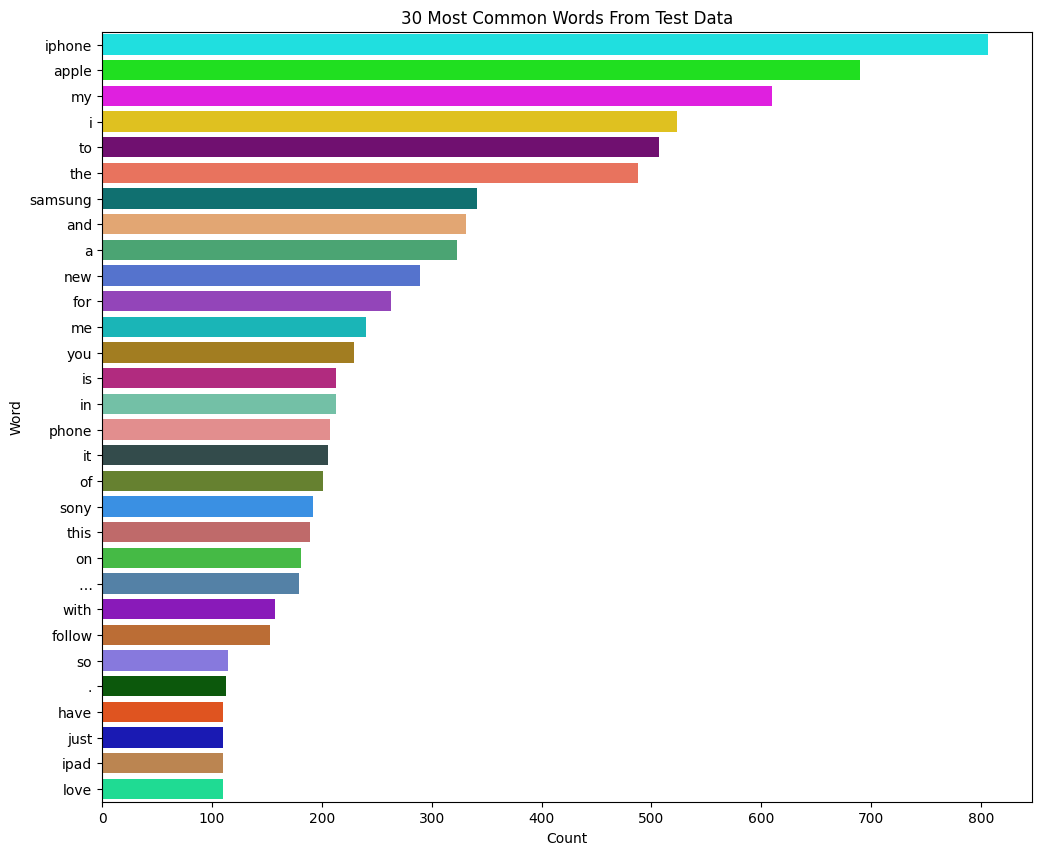

In [37]:
data_set =test_data["clean_tweet"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 10))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words From Test Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Use ELmo Model

### What is ELMo?

* No, the ELMo we are referring to isn’t the character from Sesame Street! A classic example of the importance of context.

* ELMo is a deep contextualized word in vectors or embeddings, often referred to as ELMo embedding. These word embeddings are helpful in achieving state-of-the-art (SOTA) results in several NLP tasks:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/SOTA-ELMo_2.png)

* NLP scientists globally have started using ELMo for various NLP tasks, both in research as well as the industry. You must check out the original ELMo research paper

* I don’t usually ask people to read research papers because they can often come across as heavy and complex but I’m making an exception for ELMo. This one is a really cool explanation of how ELMo was designed.

# How Does ELMo Works?

* Let’s get an intuition of how ELMo works underneath before we implement it in Python. Why is this important?

* Well, picture this. You’ve successfully copied the ELMo code from GitHub into Python and managed to build a model on your custom text data. You get average results so you need to improve the model. How will you do that if you don’t understand the architecture of ELMo? What parameters will you tweak if you haven’t studied about it?

* This line of thought applies to all machine learning algorithms. You need not get into their derivations but you should always know enough to play around with them and improve your model.

### Now, let’s come back to how ELMo works.

* As I mentioned earlier, ELMo word vectors are computed on top of a two-layer bidirectional language model (biLM). This biLM model has two layers stacked together. Each layer has 2 passes — forward pass and backward pass:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/output_YyJc8E.gif)

* The architecture above uses a character-level convolutional neural network (CNN) to represent words of a text string into raw word vectors
These raw word vectors act as inputs to the first layer of biLM
ELMo enhance the semantic understanding of sentences
The forward pass contains information about a certain word and the context (other words) before that word
* The backward pass contains information about the word and the context after it
This pair of information, from the forward and backward pass, forms the intermediate word vectors
These intermediate word vectors are fed into the next layer of biLM
The final representation (ELMo) is the weighted sum of the raw word vectors and the 2 intermediate word vectors

In [38]:
import tensorflow_hub as hub
import tensorflow as tf
model_path="/kaggle/input/elmo/tensorflow1/elmo/3/"
elmo = hub.KerasLayer(model_path, trainable=False)

# Let’s define a function for doing this:

In [39]:
def elmo_vectors(texts):
    return elmo(tf.convert_to_tensor(texts, dtype=tf.string))

# Splitting Data into Batches for Training and Testing

In [40]:
batch_size = 8

list_train = [df[i:i+batch_size] for i in range(0, df.shape[0], batch_size)]
list_test = [test_data[i:i+batch_size] for i in range(0, test_data.shape[0], batch_size)]

# Generating ELMo Embeddings for Training and Testing Data

In [41]:
elmo_train_new = np.concatenate([elmo_vectors(x['clean_tweet'].tolist()) for x in list_train], axis=0)
elmo_test_new = np.concatenate([elmo_vectors(x['clean_tweet'].tolist()) for x in list_test], axis=0)

elmo_train_new = np.expand_dims(elmo_train_new, axis=1)
elmo_test_new = np.expand_dims(elmo_test_new, axis=1)

In [42]:
label_data=df["label"]

# Split Data

In [43]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(elmo_train_new,label_data,  
                                                  random_state=42, 
                                                  test_size=0.2)

# Create LSTM Model

In [44]:
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 598,657 (2.28 MB)

 Trainable params: 598,657 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [45]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8416 - loss: 0.3442 - val_accuracy: 0.8832 - val_loss: 0.2624
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8986 - loss: 0.2413 - val_accuracy: 0.8813 - val_loss: 0.2663
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8975 - loss: 0.2346 - val_accuracy: 0.8807 - val_loss: 0.2647
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9015 - loss: 0.2333 - val_accuracy: 0.8870 - val_loss: 0.2523
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9055 - loss: 0.2187 - val_accuracy: 0.8845 - val_loss: 0.2537
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9098 - loss: 0.2169 - val_accuracy: 0.8939 - val_loss: 0.2471
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9044 - loss: 0.2226 - val_accuracy: 0.8889 - val_loss: 0.2555
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9186 - loss: 0.1984 - val_accuracy: 0.

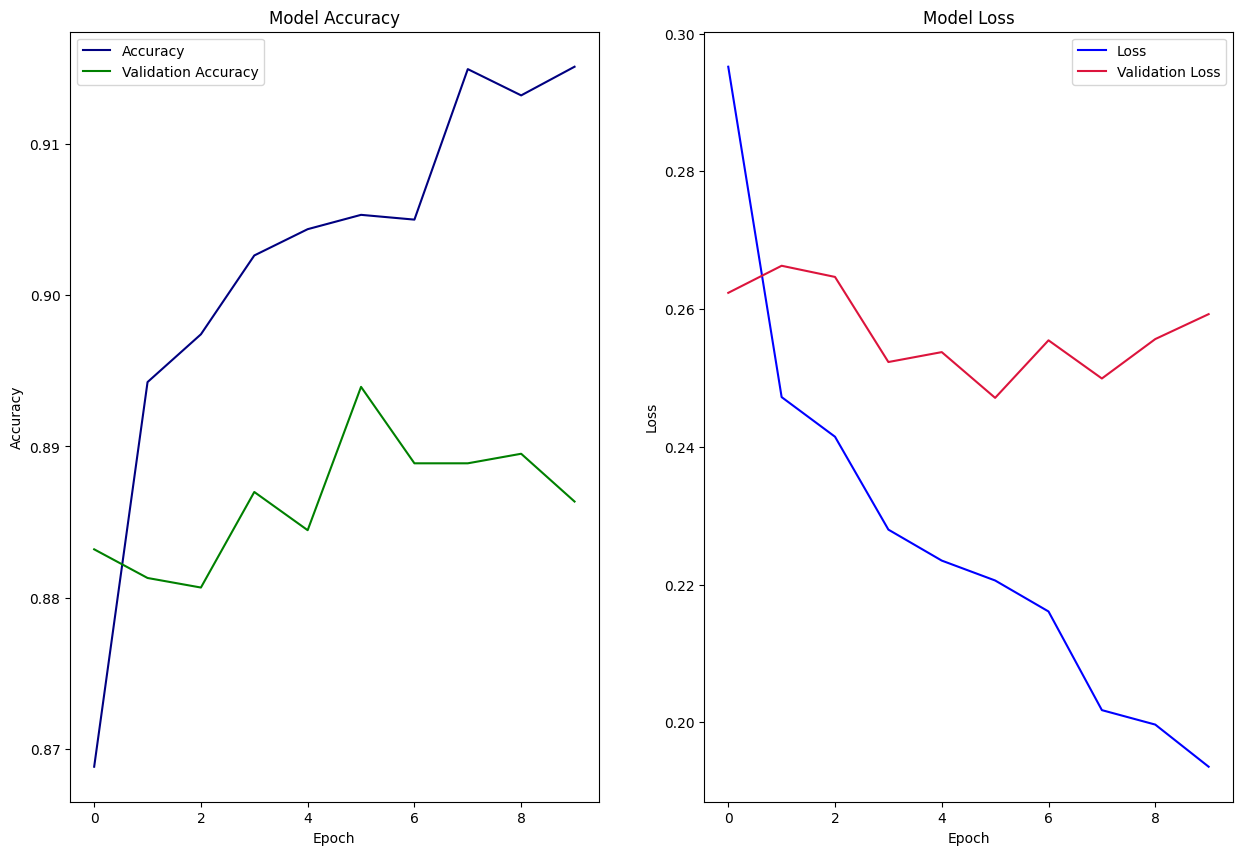

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

# First subplot
ax[0].plot(history.history['accuracy'],label="Accuracy",color="navy")
ax[0].plot(history.history['val_accuracy'],label="Validation Accuracy",color="green")
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='best')

# Second subplot
ax[1].plot(history.history['loss'],label="Loss",color="blue")
ax[1].plot(history.history['val_loss'],label="Validation Loss",color="crimson")
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')

plt.show()

In [47]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    log_loss
)

In [48]:
label_name=["Positive","Negative"]
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')

recall = recall_score(y_test, y_pred, average='binary')

f1 = f1_score(y_test, y_pred, average='binary')

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred,target_names=label_name)


print("########################################################################################")
print("Accuracy:", accuracy)
print("########################################################################################")
print("Precision:", precision)
print("########################################################################################")
print("Recall:", recall)
print("########################################################################################")
print("F1 Score:", f1)
print("########################################################################################")
print("Confusion Matrix:\n", conf_matrix)
print("########################################################################################")
print("Classification Report:\n", class_report)
print("########################################################################################")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
########################################################################################
Accuracy: 0.8863636363636364
########################################################################################
Precision: 0.7727272727272727
########################################################################################
Recall: 0.8263888888888888
########################################################################################
F1 Score: 0.7986577181208053
########################################################################################
Confusion Matrix:
 [[1047  105]
 [  75  357]]
########################################################################################
Classification Report:
               precision    recall  f1-score   support

    Positive       0.93      0.91      0.92      1152
    Negative       0.77      0.83      0.80       432

    accuracy                           0.89      1584
   macro avg       0.85 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


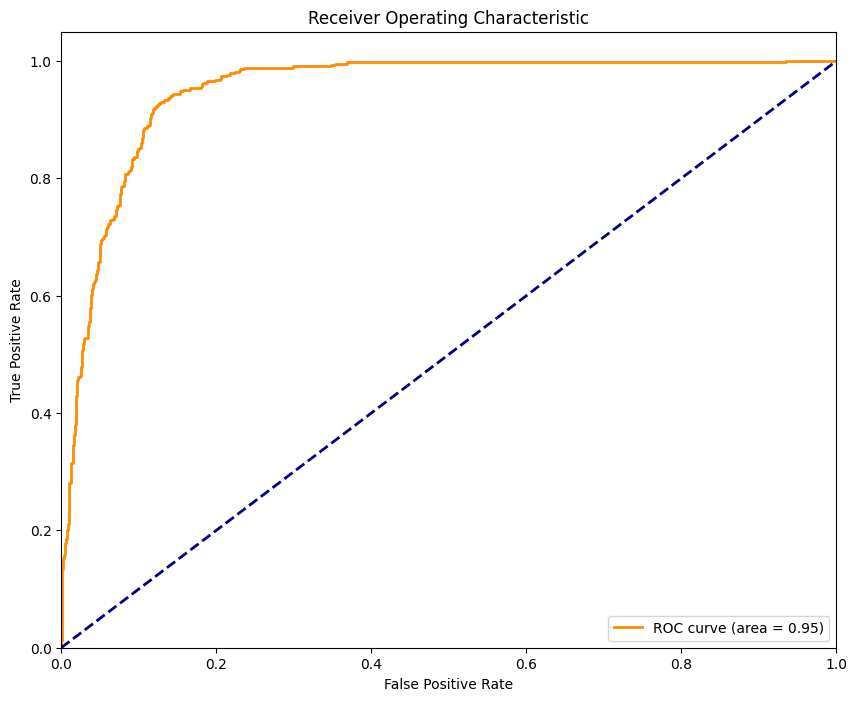

In [49]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


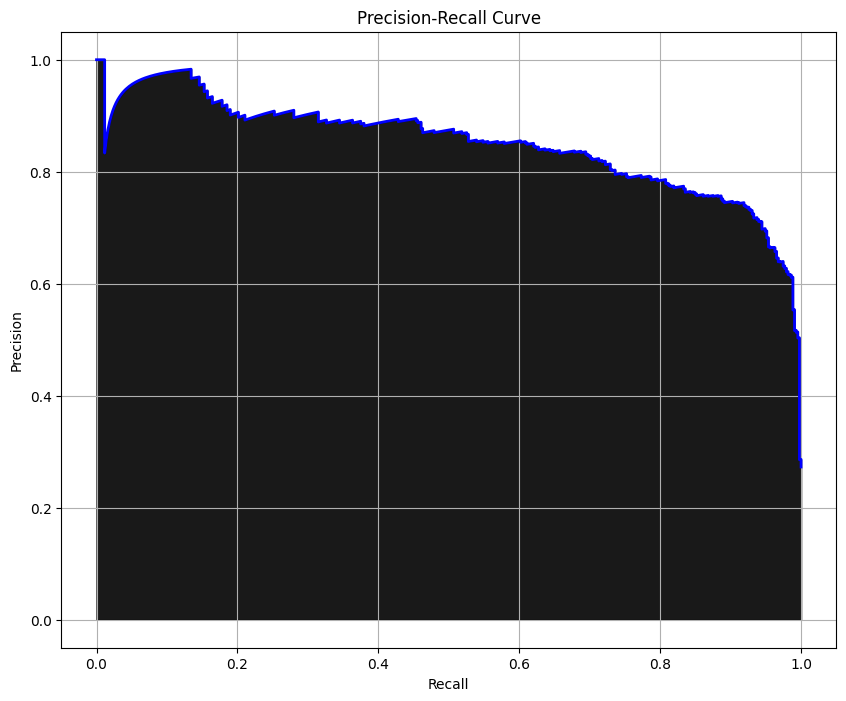

In [50]:


precision, recall, thresholds = precision_recall_curve(y_test, model.predict(X_test))

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='blue', lw=2)
plt.fill_between(recall, precision, color='black', alpha=0.9)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


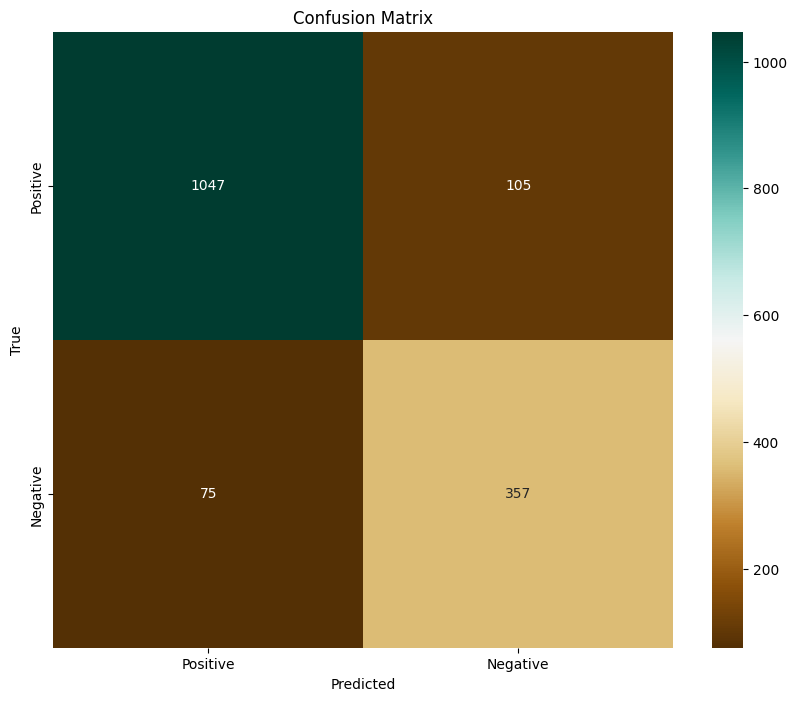

In [51]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="BrBG", xticklabels=label_name, yticklabels=label_name)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

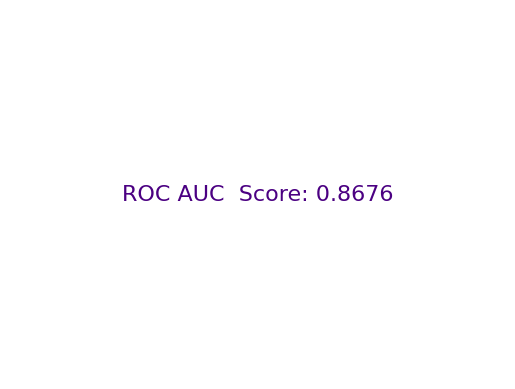

In [52]:
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="indigo")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

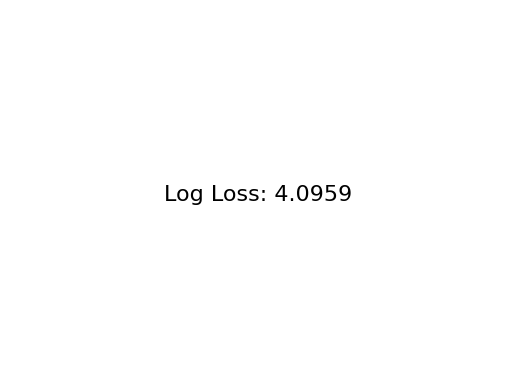

In [53]:
logarithm_loss=log_loss(y_test,y_pred)
plt.plot([])
plt.text(0,0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center',color="black")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

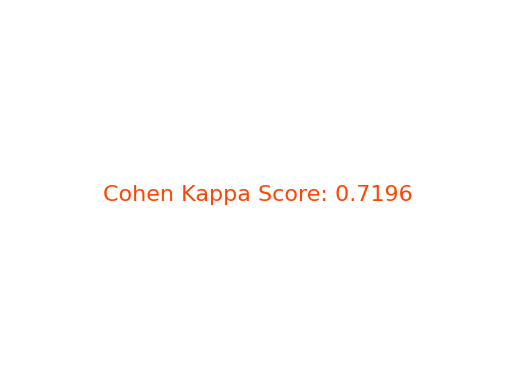

In [54]:
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef
kappa = cohen_kappa_score(y_test,y_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

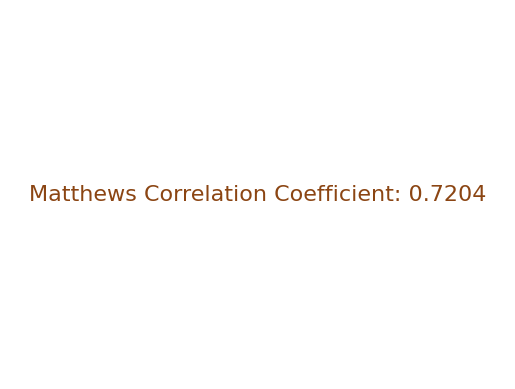

In [55]:
mcc = matthews_corrcoef(y_test,y_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# Custom Data Prediction

In [56]:

# Define your custom data (sample)
custom_data = ["This is a great product!", "I did not like this item!"]

# Preprocess custom data (assuming basic cleaning for example)
custom_data_cleaned = [text.lower() for text in custom_data]

# Get ELMo embeddings for the custom data
custom_data_embeddings = np.concatenate([elmo_vectors(custom_data_cleaned)], axis=0)

# Expand dimensions to match model input format
custom_data_embeddings = np.expand_dims(custom_data_embeddings, axis=1)

# Predict using the trained model
custom_predictions = model.predict(custom_data_embeddings)

# Convert predictions to binary (0 for positive, 1 for negative)
custom_predictions = (custom_predictions > 0.5).astype("int32")


for text, prediction in zip(custom_data, custom_predictions):
    sentiment = "Negative" if prediction == 1 else "Positive"
    print(f"Text: {text}")
    print(f"Prediction: {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: This is a great product!
Prediction: Negative
Text: I did not like this item!
Prediction: Negative


# Prediction On test Data

In [57]:
test_data.head()

id                                        clean_tweet
0  7921  i hate the new iphone upgrade. won't let me do...
1  7922  currently shitting my fucking pants. apple ima...
2  7923  i'd like to puts some cdroms on my ipad, is th...
3  7924  my ipod is officially dead. i lost all my pict...
4  7925  been fighting itunes all night i only want the...

In [58]:
prediction=model.predict(elmo_test_new)
prediction=(prediction>0.5).astype(int)
test_data["predicted_label"]=prediction
test_data["predicted_label"]=test_data["predicted_label"].map({0:"Positive",1:"Negative"})
test_data.head()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


id                                        clean_tweet predicted_label
0  7921  i hate the new iphone upgrade. won't let me do...        Negative
1  7922  currently shitting my fucking pants. apple ima...        Negative
2  7923  i'd like to puts some cdroms on my ipad, is th...        Negative
3  7924  my ipod is officially dead. i lost all my pict...        Negative
4  7925  been fighting itunes all night i only want the...        Negative